# Отборочное задание для претендента на стажировку в Отдел электронного трейдинга

Автор: Никита Ясенков  <br>
Email: yasenkov.n@gmail.com <br>
LinkedIn: https://www.linkedin.com/in/nikita-yasenkov/ <br>
Github: https://github.com/Nikita-Yasenkov

## 1. Загружаем котировки

Для начала необходимо импортировать нужные библиотеки. 

In [1]:
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sts
import math
from sklearn.utils import shuffle
import pylab
import os

Запрашиваем ключ доступа к базе котировок и сохраняем его в константе:

In [2]:
API_KEY = 'TUFHZEZV2L6BJVY2'

Процесс импорта котировок для различных акций схож, поэтому напишем функцию, которую будем использовать повторно для извлечения данных:

In [3]:
def get_price_history(ticker):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol={ticker}&apikey={API_KEY}'
    r = requests.get(url)
    data = r.json()
    return data

Функция возвращает данные в формате 'json', по сути это словарь в словаре. В дальнейшем нам необходимо будет написать функцию, которая сможет обрабатывать эти данные. Поскольку, помимо необходимой нам цены закрытия, датасет содержит цены открытия, максимум и минимум, а также объем торгов. Нам необходимо это отфильтровать

Теперь для извлечения данных необходимо передать функции только тикер акции. Сохраним тикеры компаний в соответствующих переменных:

In [4]:
apple_ticker = 'AAPL'
alphabet_ticker = 'GOOGL'
facebook_ticker = 'FB'
aapl_data = get_price_history(apple_ticker)
alphabet_data = get_price_history(alphabet_ticker)
facebook_data = get_price_history(facebook_ticker)

Опишем функцию обработки извлеченного датасета. Я предпочитаю писать функции, чтобы в дальнейшем их можно было применять повтроно на любых тикерах. По условию нам нужны только цены закрытия и только за последние 10 лет. День отсчета берем за последний день, в который была открыта биржа (как известно, в выходные и праздничные дни биржа закрыта), и передадим период времени, за который нам нужны данные. В данном случае это 10 лет, поэтому просто умножим 10 на 365 дней. 

In [5]:
def get_daily_data(start_date, days_delta, data):
    # Создаем массив дат за последние 10 лет
    date_list = [(start_date - dt.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(days_delta)]
    # Фильтруем входные данные для дат за последние 10 лет
    daily_data = {d:data['Time Series (Daily)'][d] for d in date_list if d in data['Time Series (Daily)'].keys()}
    # Назначаем только цену закрытия для даты
    daily_data = {d:float(daily_data[d]['4. close']) for d in daily_data.keys()}
    return daily_data    

Для удобства визуализации и дальнейших расчетов сохраним полученные данные в pandas dataframe.

In [6]:
today = dt.date.today()
aapl_daily_data = get_daily_data(today, 365*10, aapl_data)
aapl_df = pd.DataFrame(data=aapl_daily_data.items())
aapl_df = aapl_df.rename(columns={0:'date', 1:'price'})

alphabet_daily_data = get_daily_data(today, 365*10, alphabet_data)
alphabet_df = pd.DataFrame(data=alphabet_daily_data.items())
alphabet_df = alphabet_df.rename(columns={0:'date', 1:'price'})

fb_daily_data = get_daily_data(today, 365*10, facebook_data)
fb_df = pd.DataFrame(data=fb_daily_data.items())
fb_df = fb_df.rename(columns={0:'date', 1:'price'})

Для убедительности правильности работы функций, сравним длины датафреймов по анализируемым компаниям:

In [7]:
g = len(alphabet_df)
a = len(aapl_df)
f = len(fb_df)
print(f'Alphabet {g}\n', f'Apple {a}\n', f'Facebbok {f}')

Alphabet 2513
 Apple 2513
 Facebbok 2286


Длины Google и Apple одинаковые, а вот длина таблицы Facebook отличается. Возможно это связано с тем, что компания торгуется на бирже меньше 10 лет. Спросим в гугле:

![image.png](attachment:image.png)

Действительно, Facebook начал торговаться на бирже с 18 мая 2012 года, что меньше чем 10 лет, от сегодняшней даты.

**Вывод по первой части:** По итогу выполнения первого пункта задания, были загружены данные по трем акциям, и представлены в датафреймах. Данные готовы к анализу.

## 2. Расчет Daily Returns 

Точно также создадим функцию для расчета ретернов по дням, которую применим на каждую акцию:

In [8]:
def get_returns(df):
    daily_returns = []
    for p in range(1, len(df['price'])):
        daily_returns.append((df['price'][p-1] - df['price'][p])/df['price'][p]*100)
    daily_returns.append(0) # добавляем 0 в конце, чтобы сравнять длину списка и датафрейма
    return np.array(daily_returns)    

In [9]:
aapl_df['daily_returns %'] = get_returns(aapl_df)
alphabet_df['daily_returns %'] = get_returns(alphabet_df)
fb_df['daily_returns %'] = get_returns(fb_df)

### Расчет статистик 

Избавляемся от последнего элемента датафрейма, на случай, если он повлияет на расчет статистик.

In [10]:
aapl_stats = aapl_df['daily_returns %'].drop([a-1])
aapl_stats.describe()

count    2512.000000
mean        0.047082
std         2.895714
min       -85.485695
25%        -0.730901
50%         0.076090
75%         1.036088
max        11.980824
Name: daily_returns %, dtype: float64

In [11]:
fb_stats = fb_df['daily_returns %'].drop([f-1])
fb_stats.describe()

count    2285.000000
mean        0.121359
std         2.338241
min       -18.960920
25%        -0.943846
50%         0.105632
75%         1.233711
max        29.607695
Name: daily_returns %, dtype: float64

In [12]:
alphabet_stats = alphabet_df['daily_returns %'].drop([a-1])
alphabet_stats.describe()

count    2512.000000
mean        0.085481
std         1.916715
min       -49.652013
25%        -0.639590
50%         0.096808
75%         0.915871
max        16.258433
Name: daily_returns %, dtype: float64

Глядя только лишь на цифры очень легко ввести себя в заблуждение, поэтому при анализе данных стоит строить различные графики. Например, построим функцию распределения для всего интервала значений.

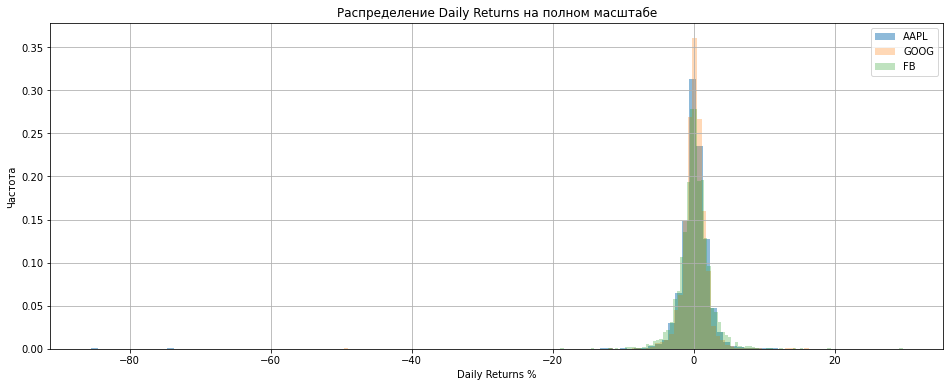

In [13]:
fig = plt.figure(figsize=(16, 6))
aapl_df['daily_returns %'].hist(bins=100, density=True, alpha=0.5);
alphabet_df['daily_returns %'].hist(bins=100, density=True, alpha=0.3);
fb_df['daily_returns %'].hist(bins=100, density=True, alpha=0.3);
plt.title('Распределение Daily Returns на полном масштабе')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
plt.legend(['AAPL', 'GOOG', 'FB']);

Из графика выше вполне очевидно, что основная масса значений находится в пределах от -10 до +10. В аналитике данных, значения, которые резко выбиваются из общего распределения, называются выбросами. Перемасштабируем график, и посмотрим на гистограмму в этих пределах. 

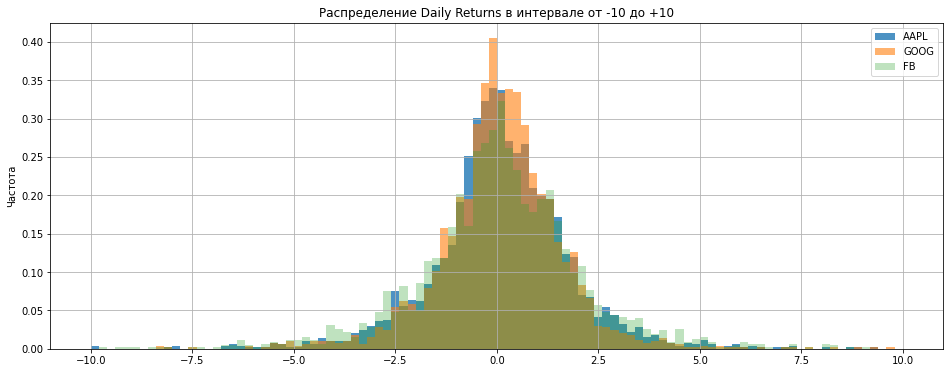

In [14]:
fig = plt.figure(figsize=(16, 6))
aapl_df['daily_returns %'].hist(bins=100, range=(-10, 10), density=True, alpha=0.8);
alphabet_df['daily_returns %'].hist(bins=100, range=(-10, 10), density=True, alpha=0.6);
fb_df['daily_returns %'].hist(bins=100, range=(-10, 10), density=True, alpha=0.3);
plt.title('Распределение Daily Returns в интервале от -10 до +10');
plt.ylabel('Частота');
plt.legend(['AAPL', 'GOOG', 'FB']);

После ремасштабирования графика мы видим, что распределение больше походит на нормальное. Мы можем нанести теоретическую гладкую функцию распределения на каждый график в отдельности и оценить сходство с нормальным распределением. 

### Анализ AAPL

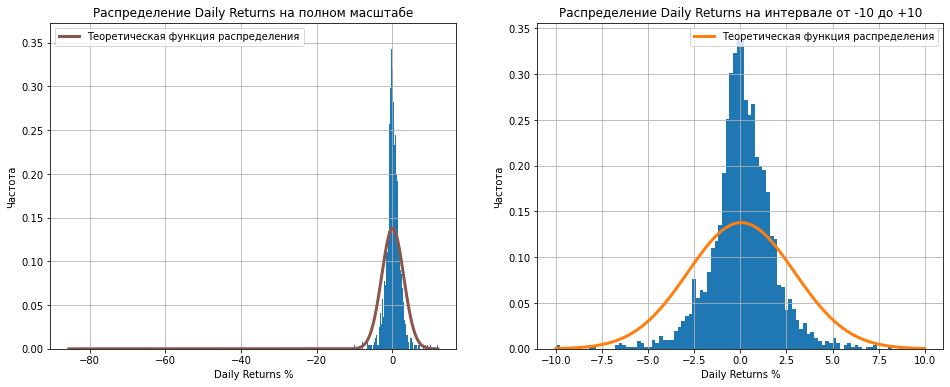

In [15]:
mu = aapl_stats.describe()['mean']
sigma = aapl_stats.describe()['std']
# Задаем нормальное распределение
norm_rv = sts.norm(loc=mu, scale=sigma)

x1 = np.linspace(aapl_stats.describe()['min'], aapl_stats.describe()['max'], 1000)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
aapl_df['daily_returns %'].hist(bins=1000, density=True);
plt.title('Распределение Daily Returns на полном масштабе')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x1);
plt.plot(x1, pdf);
plt.plot(x1, pdf, label='Теоретическая функция распределения', c='C15', linewidth=3);
plt.legend();

x2 = np.linspace(-10, 10, 100)
ax = fig.add_subplot(1,2,2)
aapl_df['daily_returns %'].hist(bins=100, density=True, range=(-10, 10));
plt.title('Распределение Daily Returns на интервале от -10 до +10')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x2);
plt.plot(x2, pdf, label='Теоретическая функция распределения', linewidth=3);
plt.legend();

Для проверки соответствия нашего распределения нормальному, построим QQ-plot. Но для начала стоит избавиться от выбросов. Как мы уже отметили ранее, нормальному соответствует распределение на интервале от -10 до +10. Для начала, посчитаем сколько всего выбросов в выборке.

In [16]:
aapl_df[(aapl_df['daily_returns %'] < -10) | (aapl_df['daily_returns %'] > 10)].count()

date               7
price              7
daily_returns %    7
dtype: int64

Всего 7 значений выпадают из нашего интервала. Давайте избавимся от них. 

In [17]:
aapl_df_drop = aapl_df.drop(aapl_df[(aapl_df['daily_returns %'] < -10) | (aapl_df['daily_returns %'] > 10)].index)

Теперь, на чистых данных, можно оценить соответствие распределения ретернов нормальному распределению.

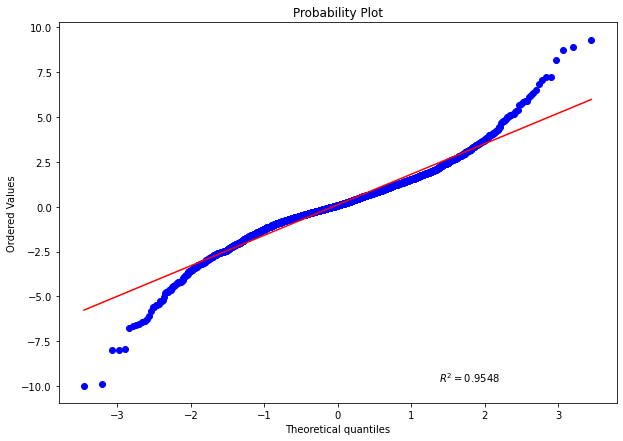

In [18]:
plt.figure(figsize=(10, 7))
sts.probplot(aapl_df_drop['daily_returns %'], dist='norm', plot=plt, rvalue=True)
plt.show()

Исходя из полученного графика, и рассчитанного коэффициента корреляции, можно сделать вывод, что распределение ретернов соответствует нормальному (R^2 > 95%)

**Критерий Стьюдента** <br>
Применим критерий Стьюдента для проверки выборки на соответствие нормальному распределению. Для этого добавим в датафрейм столбец с нормальным распределением и применим метод для расчета критерия стъюдента.

**Гипотеза H0:** Распределение соответсвтует нормальному, <br>
**Гипотеза H1:** Не соответствует

In [19]:
aapl_df_drop['gaussian_dist'] = sts.norm(
    aapl_df_drop['daily_returns %'].mean(), aapl_df_drop['daily_returns %'].std()).rvs(
    int(aapl_df_drop['daily_returns %'].count()))

In [20]:
sts.ttest_ind(aapl_df_drop['daily_returns %'], aapl_df_drop['gaussian_dist'])

Ttest_indResult(statistic=0.3642550997071977, pvalue=0.7156828973588315)

**Вывод:** P-value больше 0.05, а значит гипотезу мы отбрасывать не можем. Следовательно, распределение соответствует нормальному.

**Оценка распределения доходностей по времени**

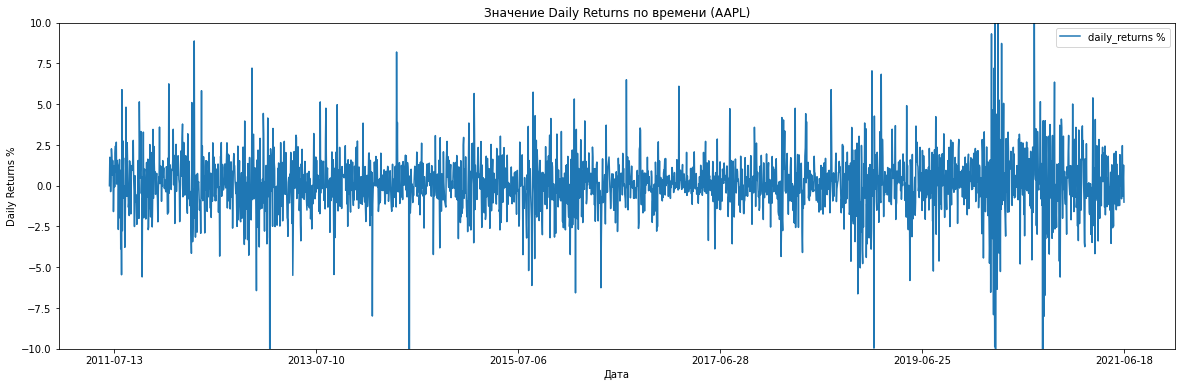

In [21]:
aapl_df.plot(x='date', y='daily_returns %', figsize=(20, 6)).invert_xaxis();
plt.ylim(-10, 10);
plt.title('Значение Daily Returns по времени (AAPL)')
plt.xlabel('Дата');
plt.ylabel('Daily Returns %');

Так как очень много значений, для лучшей наглядности рассчитаем медианные значения по месяцам и нанесем их на график. Таким способом пользуются некоторые брокеры.

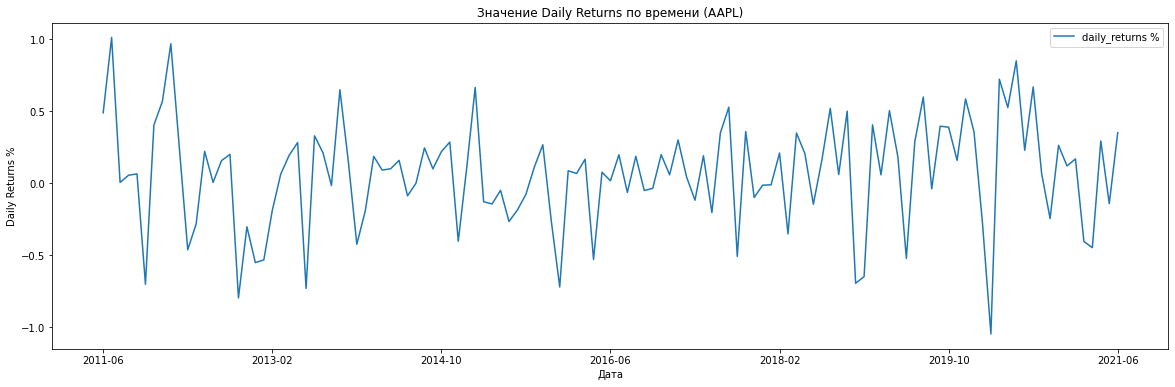

In [22]:
# Конвертируем столбец date в формат datetime
aapl_df['datetime'] = pd.to_datetime(aapl_df['date'])
aapl_df['month'] = aapl_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))
# Группируем по месяцам
aapl_df_med = aapl_df.groupby(['month']).median().reset_index()

aapl_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6));
plt.title('Значение Daily Returns по времени (AAPL)');
plt.xlabel('Дата');
plt.ylabel('Daily Returns %');

**Вывод:** Исходя из полученных графиков и расчетов, мы можем предположить, что дневные доходности для акций компании Apple стационарны по времени. Распределение значений соответсвтует нормальному. Это было проверено критерием стьюдента, а также из графика квантиль-квантиль

### Анализ Google

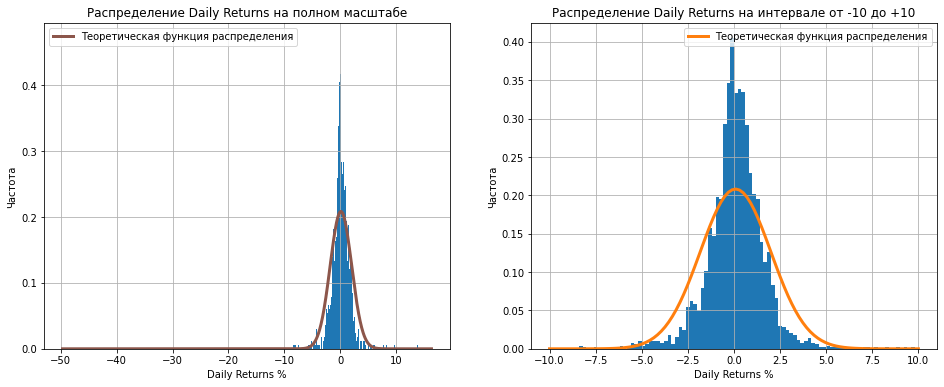

In [23]:
mu = alphabet_stats.describe()['mean']
sigma = alphabet_stats.describe()['std']
# Задаем нормальное распределение
norm_rv = sts.norm(loc=mu, scale=sigma)

x1 = np.linspace(alphabet_stats.describe()['min'], alphabet_stats.describe()['max'], 1000)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
alphabet_df['daily_returns %'].hist(bins=1000, density=True);
plt.title('Распределение Daily Returns на полном масштабе')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x1);
plt.plot(x1, pdf);
plt.plot(x1, pdf, label='Теоретическая функция распределения', c='C15', linewidth=3);
plt.legend();

x2 = np.linspace(-10, 10, 100)
ax = fig.add_subplot(1,2,2)
alphabet_df['daily_returns %'].hist(bins=100, density=True, range=(-10, 10));
plt.title('Распределение Daily Returns на интервале от -10 до +10')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x2);
plt.plot(x2, pdf, label='Теоретическая функция распределения', linewidth=3);
plt.legend();

Считаем выбросы:

In [24]:
alphabet_df[(alphabet_df['daily_returns %'] < -10) | (alphabet_df['daily_returns %'] > 10)].count()

date               5
price              5
daily_returns %    5
dtype: int64

Избавляемся от выбросов:

In [25]:
alphabet_df_drop = alphabet_df.drop(
    alphabet_df[(alphabet_df['daily_returns %'] < -10) | (alphabet_df['daily_returns %'] > 10)].index)

**Квантиль-квантиль график**

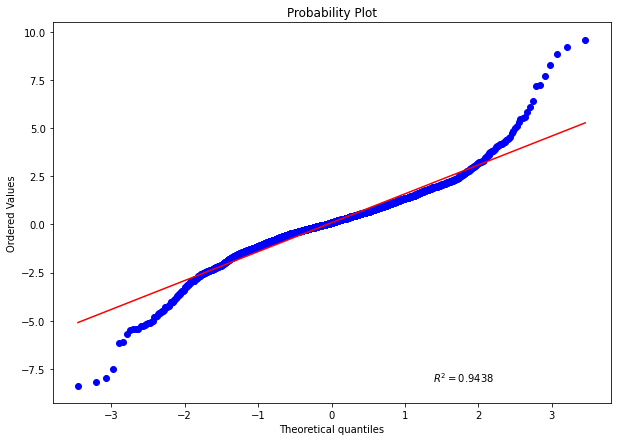

In [26]:
plt.figure(figsize=(10, 7))
sts.probplot(alphabet_df_drop['daily_returns %'], dist='norm', plot=plt, rvalue=True)
plt.show()

Коэффициент корреляции равен 0.9438. Распределение с высокой вероятностью соответствует нормальному. 

In [27]:
alphabet_df_drop['gaussian_dist'] = sts.norm(
    alphabet_df_drop['daily_returns %'].mean(), alphabet_df_drop['daily_returns %'].std()).rvs(
    int(alphabet_df_drop['daily_returns %'].count()))
sts.ttest_ind(alphabet_df_drop['daily_returns %'], alphabet_df_drop['gaussian_dist'])

Ttest_indResult(statistic=0.8111659165735583, pvalue=0.41730889832858153)

P-value больше 0.05, а значит гипотезу о соответсвтии распределения нормальному мы не можем отбросить.

Сразу же сгруппируем доходности по месяцам.

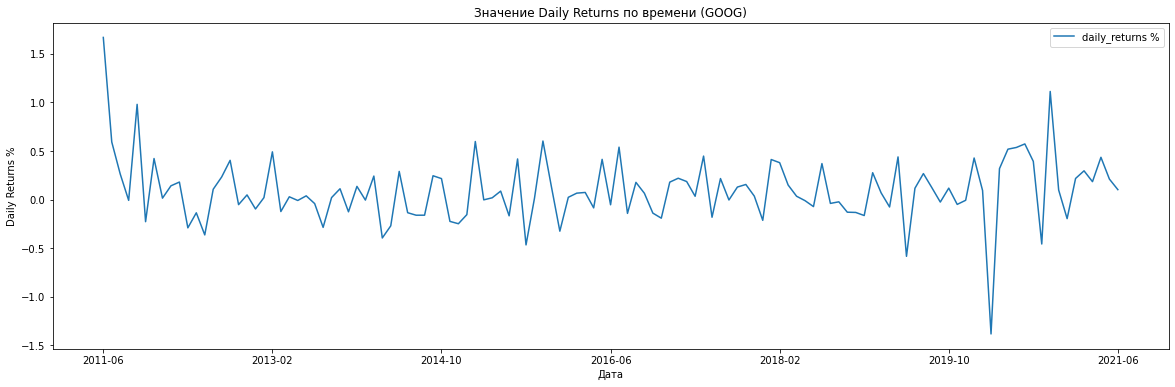

In [28]:
# Конвертируем столбец date в формат datetime
alphabet_df['datetime'] = pd.to_datetime(alphabet_df['date'])
alphabet_df['month'] = alphabet_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))
# Группируем по месяцам
alphabet_df_med = alphabet_df.groupby(['month']).median().reset_index()

alphabet_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6));
plt.title('Значение Daily Returns по времени (GOOG)');
plt.xlabel('Дата');
plt.ylabel('Daily Returns %');

**Вывод:** дневные доходности акции компании Google также стационарны по времени. Распределение значений соответствует нормальному. Это видно из графиков, а также из t-теста стьюдента.

### Анализ Facebook


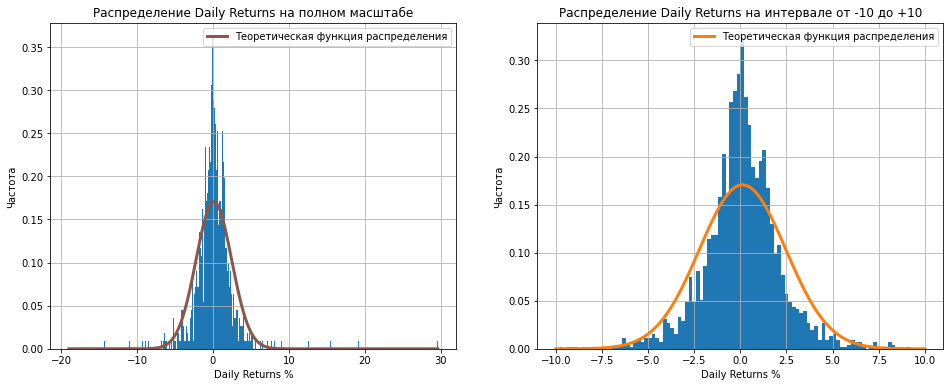

In [29]:
mu = fb_stats.describe()['mean']
sigma = fb_stats.describe()['std']
# Задаем нормальное распределение
norm_rv = sts.norm(loc=mu, scale=sigma)

x1 = np.linspace(fb_stats.describe()['min'], fb_stats.describe()['max'], 1000)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
fb_df['daily_returns %'].hist(bins=1000, density=True);
plt.title('Распределение Daily Returns на полном масштабе')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x1);
plt.plot(x1, pdf);
plt.plot(x1, pdf, label='Теоретическая функция распределения', c='C15', linewidth=3);
plt.legend();

x2 = np.linspace(-10, 10, 100)
ax = fig.add_subplot(1,2,2)
fb_df['daily_returns %'].hist(bins=100, density=True, range=(-10, 10));
plt.title('Распределение Daily Returns на интервале от -10 до +10')
plt.xlabel('Daily Returns %');
plt.ylabel('Частота');
pdf = norm_rv.pdf(x2);
plt.plot(x2, pdf, label='Теоретическая функция распределения', linewidth=3);
plt.legend();

Что касается акций компании Facebook, здесь сразу видно, что экстремальные значения выбросов не такие большие, как для акций Google или Apple. Основная масса значений также распределена в пределах от -10 до +10. Посчитаем выбросы:

In [30]:
fb_df[(fb_df['daily_returns %'] < -10) | (fb_df['daily_returns %'] > 10)].count()

date               11
price              11
daily_returns %    11
dtype: int64

Однако, количество значений за пределами установленного интервала несколько выше, чем для акций Google и Apple. Избавимся от них:

In [31]:
fb_df_drop = fb_df.drop(fb_df[(fb_df['daily_returns %'] < -10) | (fb_df['daily_returns %'] > 10)].index)

**Квантиль-квантиль график**

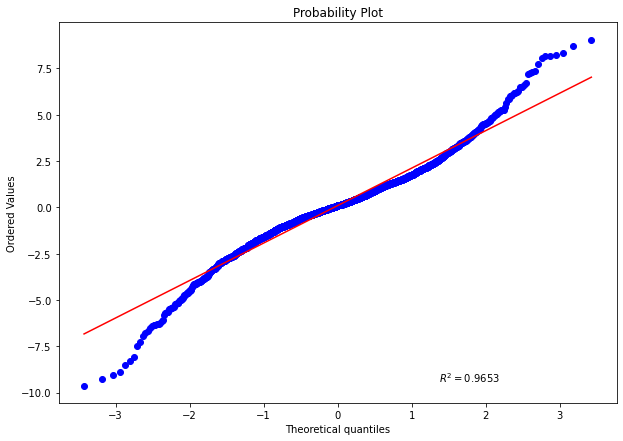

In [32]:
plt.figure(figsize=(10, 7))
sts.probplot(fb_df_drop['daily_returns %'], dist='norm', plot=plt, rvalue=True)
plt.show()

Коэффициент корреляции 0.9653, значит распределение с высокой долей вероятности соответствует нормальному. 

In [33]:
fb_df_drop['gaussian_dist'] = sts.norm(
    fb_df_drop['daily_returns %'].mean(), fb_df_drop['daily_returns %'].std()).rvs(
    int(fb_df_drop['daily_returns %'].count()))
sts.ttest_ind(fb_df_drop['daily_returns %'], fb_df_drop['gaussian_dist'])

Ttest_indResult(statistic=-0.5418215507193441, pvalue=0.5879679863399961)

P-value больше 0.05, значит гипотезу о соответствии данного распределения нормальному мы отбросить не можем.

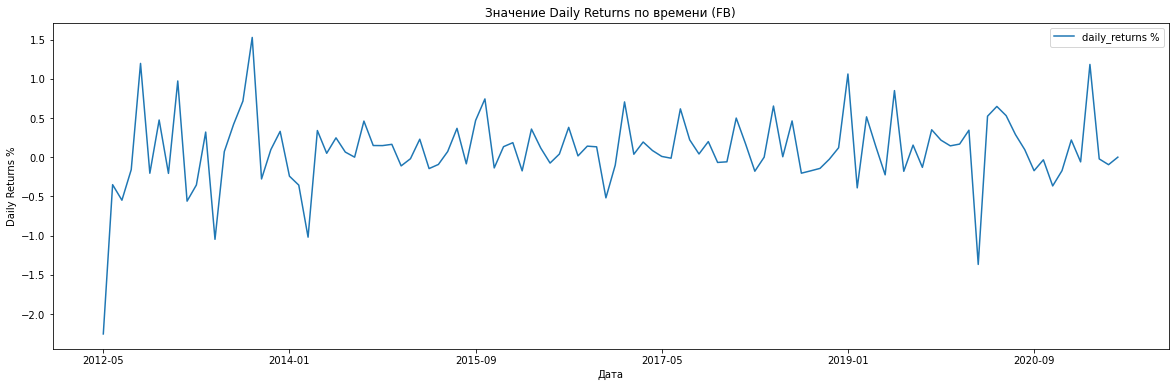

In [34]:
# Конвертируем столбец date в формат datetime
fb_df['datetime'] = pd.to_datetime(fb_df['date'])
fb_df['month'] = fb_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))
# Группируем по месяцам
fb_df_med = fb_df.groupby(['month']).median().reset_index()

fb_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6));
plt.title('Значение Daily Returns по времени (FB)');
plt.xlabel('Дата');
plt.ylabel('Daily Returns %');

**Вывод**: что касается доходностей акций FB, то они также соответсвтуют нормальному распределению. Это было подтверждено визуально, с помощью t-теста стьюдента, и из графика квантиль-квантиль. Экстремальные значения распределения меньше, чем у акций Google и Apple, но количество выбросов больше. 

Нанесем все три серии на один график:

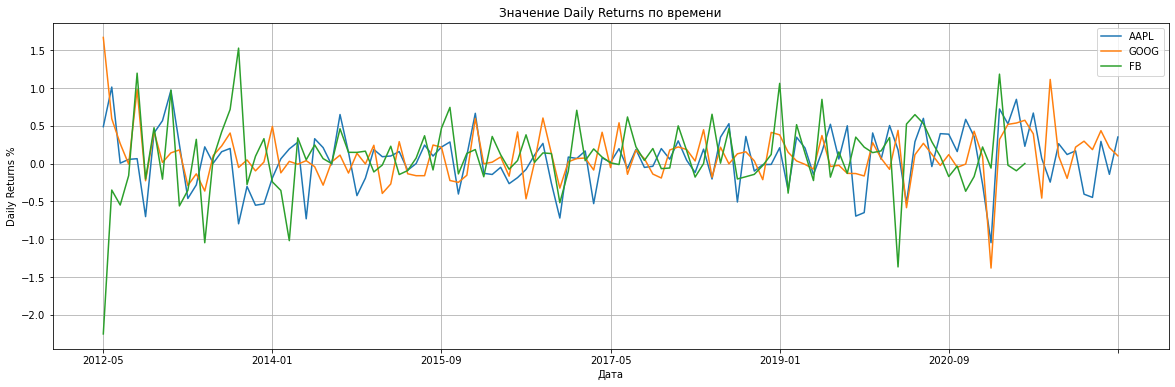

In [35]:
ax = aapl_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6));
alphabet_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6), ax=ax);
fb_df_med.plot(x='month', y='daily_returns %', figsize=(20, 6), ax=ax);
plt.legend(['AAPL', 'GOOG', 'FB']);
plt.grid();
plt.title('Значение Daily Returns по времени');
plt.xlabel('Дата');
plt.ylabel('Daily Returns %');

Из графиков видны общие паттерны доходностей. Например, видна общая просадка в феврале-марте 2020 года. Видно, что facebook пролился раньше, чем Google и Apple. На следующей просадке, в конце 2020 года, Apple и Google показали похожее поведение, тогда как Facebook устоял.

Посмотрим на коэффициент корреляции между Apple и Google

In [36]:
aapl_alphabet = pd.merge(aapl_df, alphabet_df, on='date')
aapl_alphabet['daily_returns %_x'].corr(aapl_alphabet['daily_returns %_y'])

0.2830830089759455

Корреляция невысокая, имеет смысл рассматривать на более локальных участках.

Посмотрим корреляцию Facebook и Google

In [37]:
fb_alphabet = pd.merge(fb_df, alphabet_df, on='date')
fb_alphabet['daily_returns %_x'].corr(fb_alphabet['daily_returns %_y'])

0.44869044754127146

Здесь корреляция гораздо выше, однако и не так, чтобы слишком высоко

И корреляция Facebook и Apple

In [38]:
fb_aapl = pd.merge(fb_df, aapl_df, on='date')
fb_aapl['daily_returns %_x'].corr(fb_aapl['daily_returns %_y'])

0.24290316743906756

Коэффициент корреляции между акциями Facebook и Apple невысокий.

**Общий вывод**: На графиках доходностей по времени наблюдаются общие паттерны роста и падения. Между тремя предложенными на анализ акциями, наилучшая корреляция наблюдается между акциями google и Facebook. Примерно одинаковая невысокая корреляция между парами акций Apple-Facebook и Apple-Google.


## 3. Расчет PNL

Задаем нормальное распределение, по условию mean = 0, std = 1

In [39]:
norm_rv = sts.norm(0, 1)

**Расчет PNL для Apple**

Делаем 3 реализации PNL:

In [40]:
aapl_df['fi1'] = norm_rv.rvs(len(aapl_df))
aapl_df['pnl1'] = aapl_df['daily_returns %'] * aapl_df['fi1']
aapl_df['cumsum(pnl)1'] = aapl_df['pnl1'].cumsum()

aapl_df['fi2'] = norm_rv.rvs(len(aapl_df))
aapl_df['pnl2'] = aapl_df['daily_returns %'] * aapl_df['fi2']
aapl_df['cumsum(pnl)2'] = aapl_df['pnl2'].cumsum()

aapl_df['fi3'] = norm_rv.rvs(len(aapl_df))
aapl_df['pnl3'] = aapl_df['daily_returns %'] * aapl_df['fi3']
aapl_df['cumsum(pnl)3'] = aapl_df['pnl3'].cumsum()

Строим график PNL:

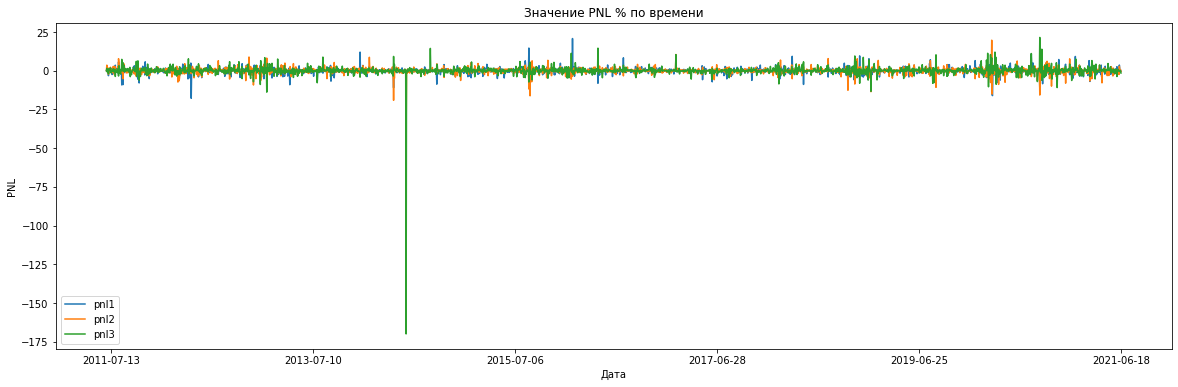

In [41]:
ax = aapl_df.plot(x='date', y=['pnl1', 'pnl2', 'pnl3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение PNL % по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

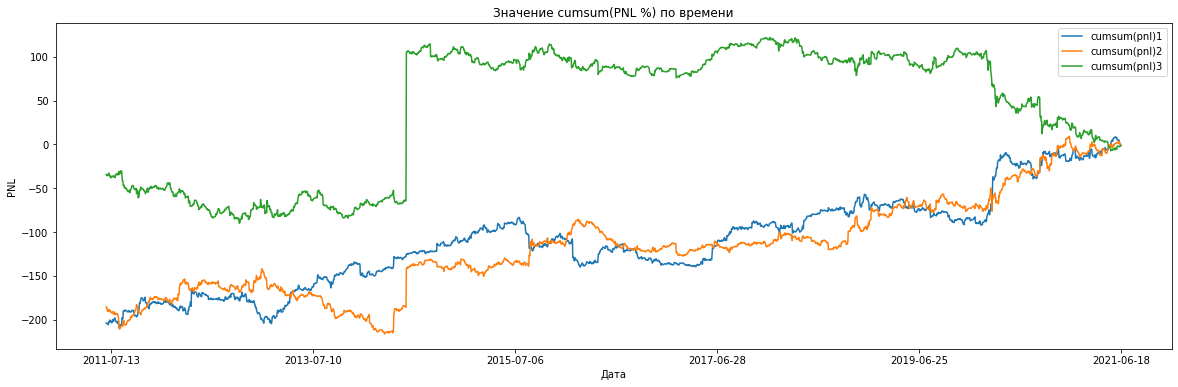

In [42]:
aapl_df.plot(x='date', y=['cumsum(pnl)1', 'cumsum(pnl)2', 'cumsum(pnl)3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение cumsum(PNL %) по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

**Расчет PNL для Google**

In [43]:
alphabet_df['fi1'] = norm_rv.rvs(len(alphabet_df))
alphabet_df['pnl1'] = alphabet_df['daily_returns %'] * alphabet_df['fi1']
alphabet_df['cumsum(pnl)1'] = alphabet_df['pnl1'].cumsum()

alphabet_df['fi2'] = norm_rv.rvs(len(alphabet_df))
alphabet_df['pnl2'] = alphabet_df['daily_returns %'] * alphabet_df['fi2']
alphabet_df['cumsum(pnl)2'] = alphabet_df['pnl2'].cumsum()

alphabet_df['fi3'] = norm_rv.rvs(len(alphabet_df))
alphabet_df['pnl3'] = alphabet_df['daily_returns %'] * alphabet_df['fi3']
alphabet_df['cumsum(pnl)3'] = alphabet_df['pnl3'].cumsum()

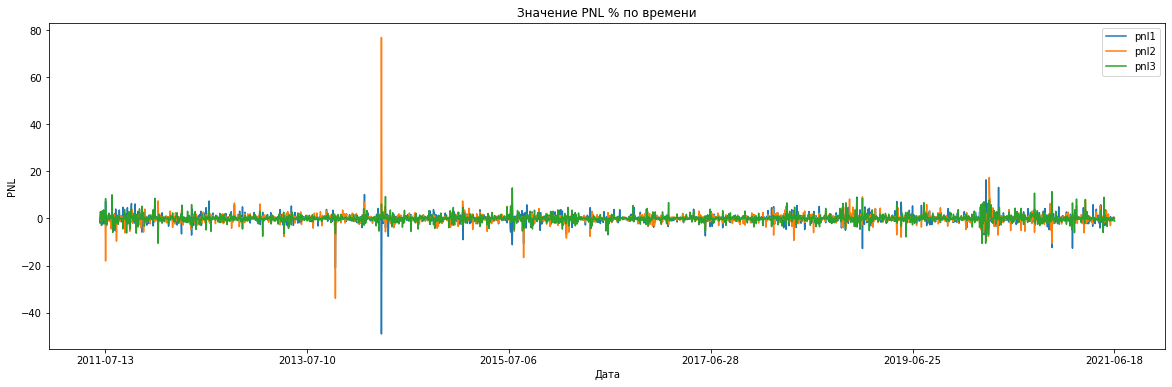

In [44]:
alphabet_df.plot(x='date', y=['pnl1', 'pnl2', 'pnl3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение PNL % по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

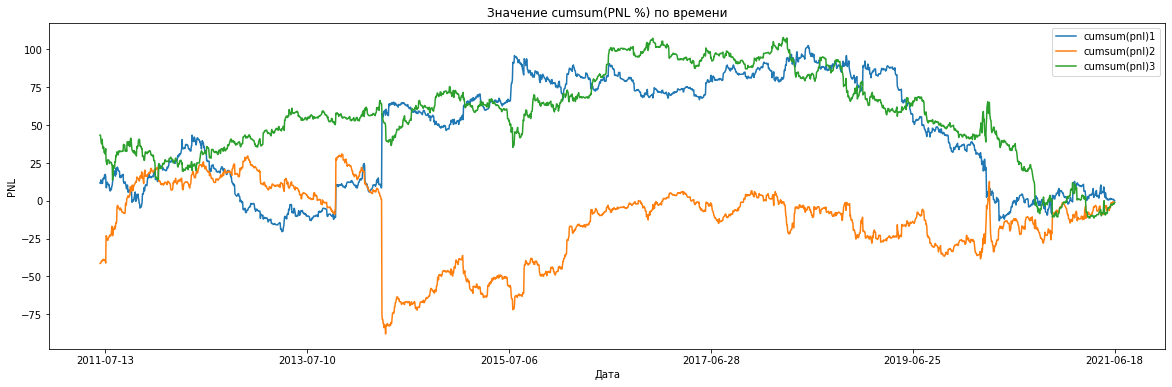

In [45]:
alphabet_df.plot(x='date', y=['cumsum(pnl)1', 'cumsum(pnl)2', 'cumsum(pnl)3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение cumsum(PNL %) по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

**Расчет PNL для Facebook**

In [46]:
fb_df['fi1'] = norm_rv.rvs(len(fb_df))
fb_df['pnl1'] = fb_df['daily_returns %'] * fb_df['fi1']
fb_df['cumsum(pnl)1'] = fb_df['pnl1'].cumsum()

fb_df['fi2'] = norm_rv.rvs(len(fb_df))
fb_df['pnl2'] = fb_df['daily_returns %'] * fb_df['fi2']
fb_df['cumsum(pnl)2'] = fb_df['pnl2'].cumsum()

fb_df['fi3'] = norm_rv.rvs(len(fb_df))
fb_df['pnl3'] = fb_df['daily_returns %'] * fb_df['fi3']
fb_df['cumsum(pnl)3'] = fb_df['pnl3'].cumsum()

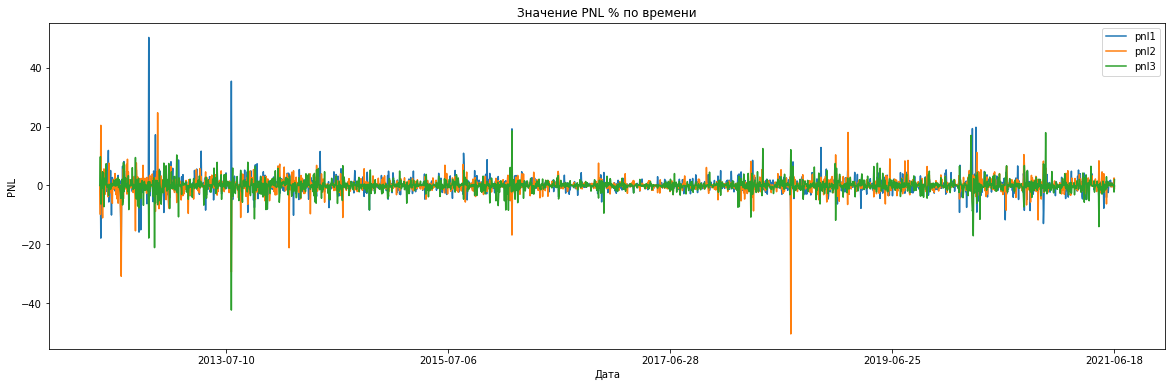

In [47]:
fb_df.plot(x='date', y=['pnl1', 'pnl2', 'pnl3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение PNL % по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

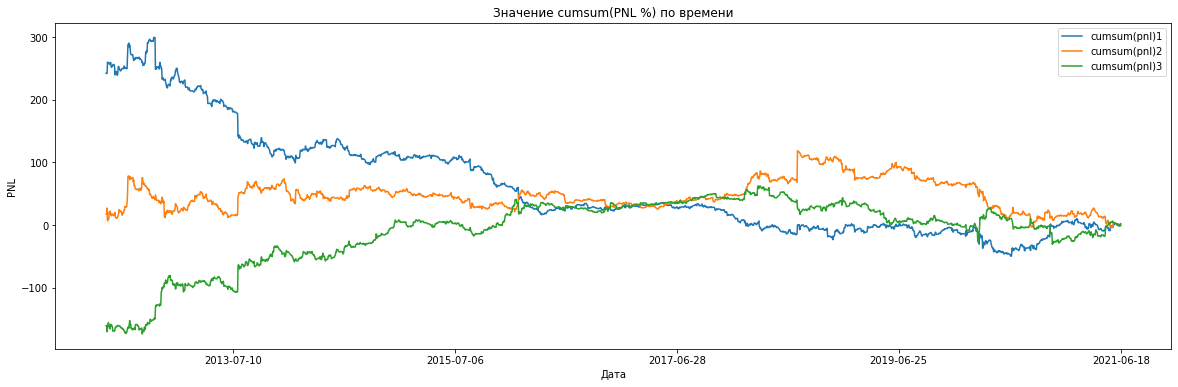

In [48]:
fb_df.plot(x='date', y=['cumsum(pnl)1', 'cumsum(pnl)2', 'cumsum(pnl)3'], figsize=(20, 6)).invert_xaxis();
plt.title('Значение cumsum(PNL %) по времени');
plt.xlabel('Дата');
plt.ylabel('PNL');

## 4. Расчет коэффициента Шарпа

**Расчет параметров для Apple**

Рассчитываем коэффициент Шарпа. В знаменатлее вместо корня из вариации будем использовать стандартное отклонение:

In [49]:
aapl_df['SR'] = aapl_df['pnl1'] / aapl_df['pnl1'].std()

Для расчета Hit Ratio, возьмем 100 реализаций fi:

In [50]:
hr = []
for i in range(len(aapl_df)):
    hr.append(sum(np.sign(norm_rv.rvs(100)) == np.sign(aapl_df['daily_returns %'][i]))/100)

In [51]:
aapl_df['hit_ratio'] = np.array(hr)

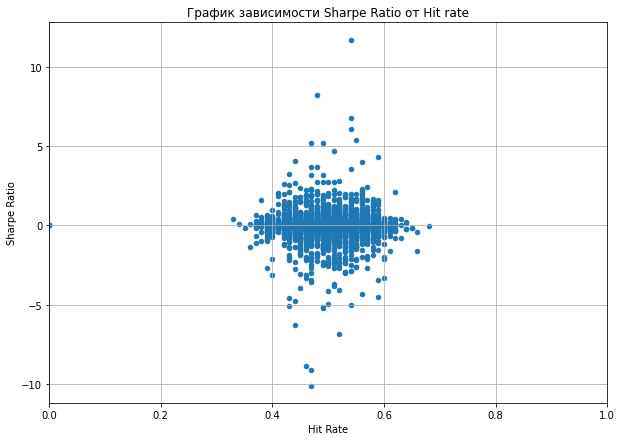

In [52]:
aapl_df.plot(kind='scatter', x='hit_ratio', y='SR', figsize=(10, 7), grid=True, xlim=(0,1));
plt.title('График зависимости Sharpe Ratio от Hit rate');
plt.xlabel('Hit Rate');
plt.ylabel('Sharpe Ratio');

**Расчет параметров для Google**

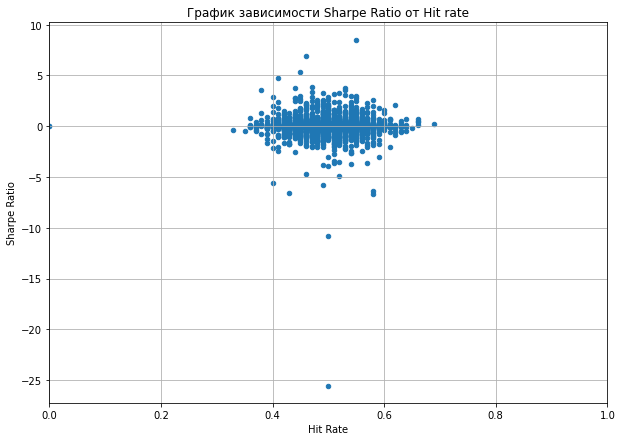

In [53]:
alphabet_df['SR'] = alphabet_df['pnl1'] / alphabet_df['pnl1'].std()
hr = []
for i in range(len(aapl_df)):
    hr.append(sum(np.sign(norm_rv.rvs(100)) == np.sign(alphabet_df['daily_returns %'][i]))/100)
alphabet_df['hit_ratio'] = np.array(hr)
alphabet_df.plot(kind='scatter', x='hit_ratio', y='SR', figsize=(10, 7), grid=True, xlim=(0,1));
plt.title('График зависимости Sharpe Ratio от Hit rate');
plt.xlabel('Hit Rate');
plt.ylabel('Sharpe Ratio');

**Расчет параметров для Facebook**

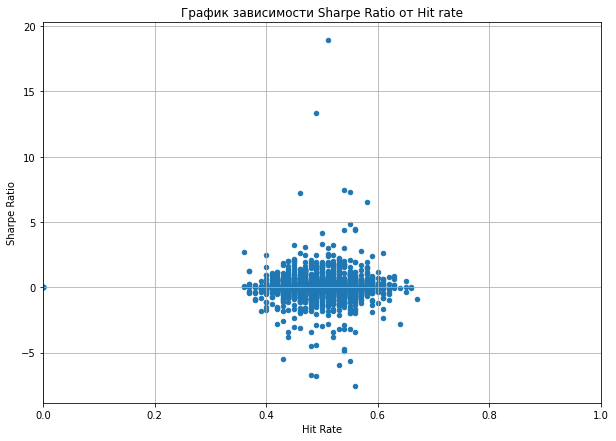

In [54]:
fb_df['SR'] = fb_df['pnl1'] / fb_df['pnl1'].std()
hr = []
for i in range(len(fb_df)):
    hr.append(sum(np.sign(norm_rv.rvs(100)) == np.sign(fb_df['daily_returns %'][i]))/100)
fb_df['hit_ratio'] = np.array(hr)
fb_df.plot(kind='scatter', x='hit_ratio', y='SR', figsize=(10, 7), grid=True, xlim=(0,1));
plt.title('График зависимости Sharpe Ratio от Hit rate');
plt.xlabel('Hit Rate');
plt.ylabel('Sharpe Ratio');

# 5. XTask

Загружаем таблицу в датафрейм:

In [55]:
xtask = pd.read_csv('xtask.csv')

Просмотрим загруженные данные:

In [56]:
xtask.head(10)

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0
5,-0.267166,-0.628857,0.633025,0.363924,1.0
6,-0.225112,0.904893,-0.226693,-0.128396,0.0
7,0.132900,0.953668,-0.193408,0.188278,1.0
8,-0.206092,0.712622,0.639996,0.200254,1.0
9,0.559334,-0.698791,0.355889,-0.268664,1.0


Просмотрим общую информацию о данных:

In [57]:
xtask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       3839 non-null   float64
 1   b       3839 non-null   float64
 2   c       3839 non-null   float64
 3   d       3839 non-null   float64
 4   class   3071 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


Из информации выше видно, что у нас есть 4 признака (фичи), 3839 экземпляров, но лейблы есть только на 3071 экземплярах. Давайте узнаем, сколько классов у нас присутствует в датасете.

In [58]:
xtask['class'].value_counts()

1.0    2026
0.0    1045
Name: class, dtype: int64

В датасете у нас всего два класса. Воспользуемся самое простой клатеризацией Kmeans. Для этого импортируем функцию KMeans из библиотеки sklearn:

In [59]:
from sklearn.cluster import KMeans

Избавимся от всех строк, в которых нет значений и удалим столбец класс для фиттинга.

In [60]:
X = xtask.dropna(axis=0)
X = X.drop(columns='class')
X = X.to_numpy()

Применим kmeans:

In [61]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

Посмотрим насколько хорошо Kmeans клатеризовал наши данные, сравнив их с исходными лейблами

In [62]:
sum(kmeans.labels_ == xtask['class'].dropna().to_numpy())

1542

Итого аккуратность предсказаний:


In [63]:
print(1545/3071)

0.5030934549006838


Всего лишь 0.5. Такое дело никуда не годится. Я предлагаю воспользоваться библиотекой TensorFlow, поскольку она позволяет легко и быстро построить нейросеть для классификации данных.

### Следующие шаги рекомендуется делать в Google Colab, т.к. могут быть проблемы с установкой TensorFlow на Windows 

Ссылка на исходный ноутбук с этим заданием. Просто подгрузите xtask.csv в корень, чтобы ноутбук заработал <br>
https://drive.google.com/file/d/1HDxMm_R38ORjp0eLmncqGgISQBwz1SrT/view?usp=sharing

In [64]:
# Импортируем необходимые библиотеки
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten

In [65]:
xtask = pd.read_csv('xtask.csv')
X = xtask.dropna(axis=0)

In [66]:
#Разделяем датасет на тренировочный и тестируемый для оценки аккуратности предсказаний
train, test = train_test_split(X, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

2456 train examples
615 test examples


In [67]:
# Отделяем фичи от лейблов
train_examples = train.loc[:, ['a', 'b', 'c', 'd']].to_numpy()
train_labels = train['class'].to_numpy()
test_examples = test.loc[:, ['a', 'b', 'c', 'd']].to_numpy()
test_labels = test['class'].to_numpy()

In [68]:
# Делаем encoding лейблов в матрицу [len(labels), 2]: 1: [0, 1], 2:[1, 0]
train_labels = tf.one_hot(train_labels, 2)
test_labels = tf.one_hot(test_labels, 2)

In [69]:
model = Sequential([
    Flatten(),
    Dense(units=512, activation='relu', name='h1'),
    Dense(units=64, activation='relu', name='h2'),
    # Sigmoid лучше всего работает на бинарной классификации (наш кейс)
    Dense(units=2, activation='sigmoid', name='output')] 
)

In [70]:
# Собираем модель. Optimizer adam, показывает лучший результат чем SGD и прочие
# accuracy - метрика оценки качества модели 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
# Тренируем модель
history = model.fit(
    train_examples,
    train_labels,
    epochs=400,
    steps_per_epoch=3,
    validation_split=0.2)

Epoch 1/400
3/3 [==============================] - 1s 90ms/step - loss: 0.6774 - accuracy: 0.6578 - val_loss: 0.6661 - val_accuracy: 0.6504
Epoch 2/400
3/3 [==============================] - 0s 22ms/step - loss: 0.6539 - accuracy: 0.6726 - val_loss: 0.6518 - val_accuracy: 0.6504
Epoch 3/400
3/3 [==============================] - 0s 23ms/step - loss: 0.6379 - accuracy: 0.6726 - val_loss: 0.6453 - val_accuracy: 0.6504
Epoch 4/400
3/3 [==============================] - 0s 24ms/step - loss: 0.6305 - accuracy: 0.6726 - val_loss: 0.6469 - val_accuracy: 0.6504
Epoch 5/400
3/3 [==============================] - 0s 28ms/step - loss: 0.6276 - accuracy: 0.6726 - val_loss: 0.6513 - val_accuracy: 0.6504
Epoch 6/400
3/3 [==============================] - 0s 22ms/step - loss: 0.6296 - accuracy: 0.6726 - val_loss: 0.6538 - val_accuracy: 0.6504
Epoch 7/400
3/3 [==============================] - 0s 24ms/step - loss: 0.6294 - accuracy: 0.6726 - val_loss: 0.6525 - val_accuracy: 0.6504
Epoch 8/400
3/3 [===

In [72]:
# Оцениваем точность предсказаний на тестовом датасете, который мы отделили вначале, перед обучением
model.evaluate(test_examples, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.9089


[0.2512190639972687, 0.9089431166648865]

Точность предсказаний 90%! Это гораздо лучше, чем при использовании обычного KMeans.

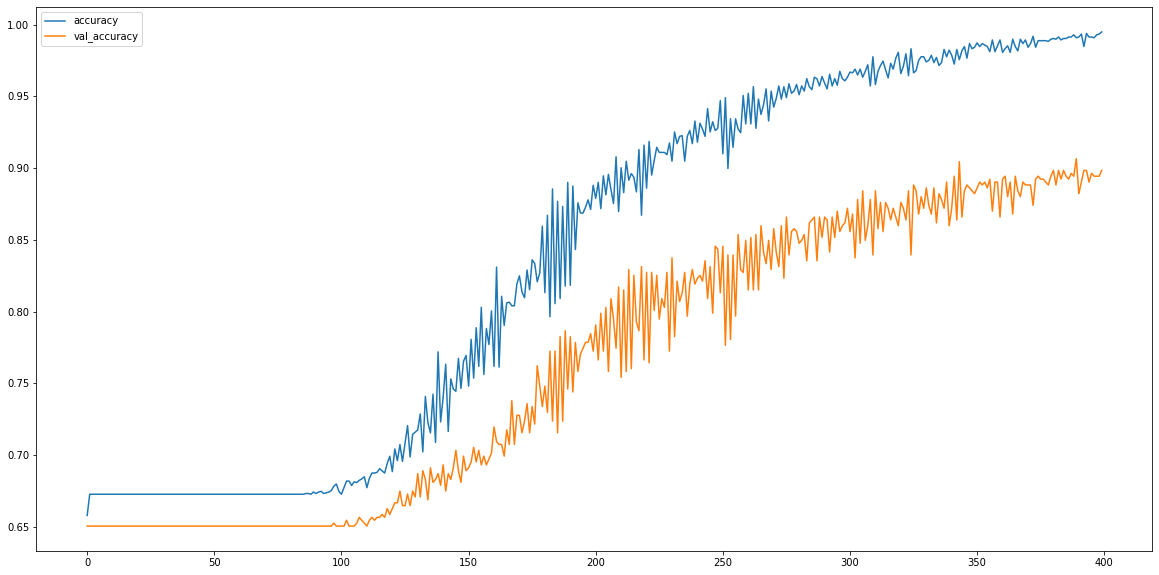

In [73]:
# Строим график сравнения точности учебного и проверочного датасетов 
ACC_COLS = ['accuracy', 'val_accuracy']
pd.DataFrame(history.history)[ACC_COLS].plot(figsize=(20, 10))

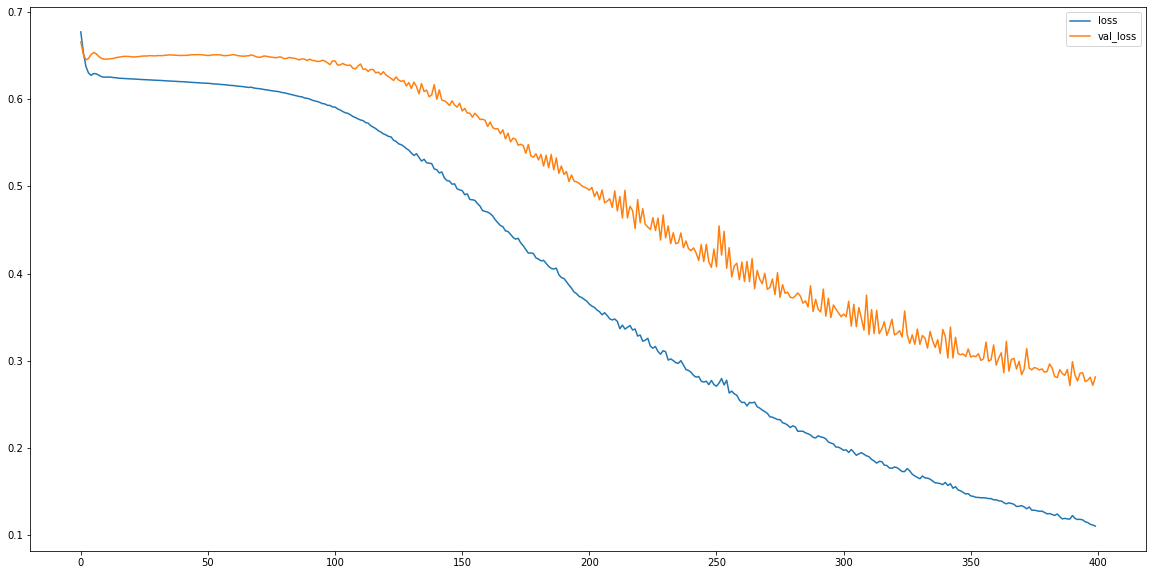

In [74]:
# Строим соответствующий график для функции потерь
LOSS_COLS = ['loss', 'val_loss']
pd.DataFrame(history.history)[LOSS_COLS].plot(figsize=(20, 10))

In [75]:
# Загрузим датасет по новой, чтобы извлечь не размеченные данные
xtask = pd.read_csv('xtask.csv')
# Заменим пропуски на что то уникальное
xtask['class'] = xtask['class'].fillna(-999.25)
predict = xtask[xtask['class'] == -999.25]
predict = predict.drop(columns='class')

In [76]:
# Делаем предсказание на основе обученной модели
prediction = model.predict(x=predict, steps=1)
predict['class'] = [list(x).index(x.max()) for x in prediction]

In [77]:
# Финальный датафрейм с предсказанными тестовыми лейблами
predict

,a,b,c,d,class
3071,-0.825795,-0.161770,0.452035,-0.295899,1
3072,-0.875079,0.390260,-0.201911,-0.071289,1
3073,0.000762,-0.801609,0.016508,0.597620,1
3074,-0.193218,-0.939776,0.251257,0.127896,1
3075,0.156078,0.344515,0.383954,0.811680,0
...,...,...,...,...,...
3834,-0.926398,0.171996,-0.333049,0.035802,1
3835,0.787500,-0.355948,0.425932,-0.200971,1
3836,0.282760,-0.569896,-0.231674,0.735929,1
3837,-0.599582,-0.749842,0.265262,-0.088739,1


In [78]:
# Экспортируем лейблы
predict.to_csv('Y.csv')

Благодарю вас за то, что рассмотрели мою задание и мою заявку на данную позицию. Пожалуйста, если возникнут вопросы по последнему заданию, обратитесь к ноутбуку по ссылке в начале задания 5. Там исходный код, поскольку TensorFlow имеет проблемы в средах Windows. 